In [5]:
# Based on https://nextjournal.com/sdanisch/julia-gpu-programming

In [6]:
import Pkg
Pkg.add("CUDAapi")
Pkg.add("CuArrays")
Pkg.build("CuArrays")


using CUDAapi
# Show us the Cuda toolkits that are available.
CUDAapi.find_toolkit()

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
  Building NNlib → `~/.julia/packages/NNlib/3krvM/deps/build.log`


6-element Array{String,1}:
 "/usr/local/cuda-10.0/"
 "/usr/local/cuda-10.1" 
 "/usr/local/cuda-10.0" 
 "/usr/local/cuda-9.2"  
 "/usr/local/cuda-9.0"  
 "/usr/local/cuda-8.0"  

In [7]:
import Pkg
Pkg.add("FileIO")
Pkg.add("GPUArrays")
Pkg.add("BenchmarkTools")
Pkg.add("ImageShow")
Pkg.add("Colors")
Pkg.add("ImageShow")
import Pkg; Pkg.add("ImageMagick")
# Pkg.add("LibCUDA")
Pkg.add("CuArrays")
using CUDAapi
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow
using CuArrays: CuArray



 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Res

┌ Info: Precompiling CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1273
┌ Warning: CuArrays.jl only supports CUDNN v7.6 or higher
└ @ CuArrays /home/ec2-user/.julia/packages/CuArrays/HE8G6/src/CuArrays.jl:121


In [8]:
Pkg.add("CUDAdrv"); using CUDAdrv; CUDAdrv.name(CuDevice(0))

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


"Tesla V100-SXM2-16GB"

In [17]:
"""
The function calculating the Julia set
"""
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end
the_range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]
function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in the_range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
				run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
      	last_jl = result
      end
      push!(times, t)
    end
  end
end

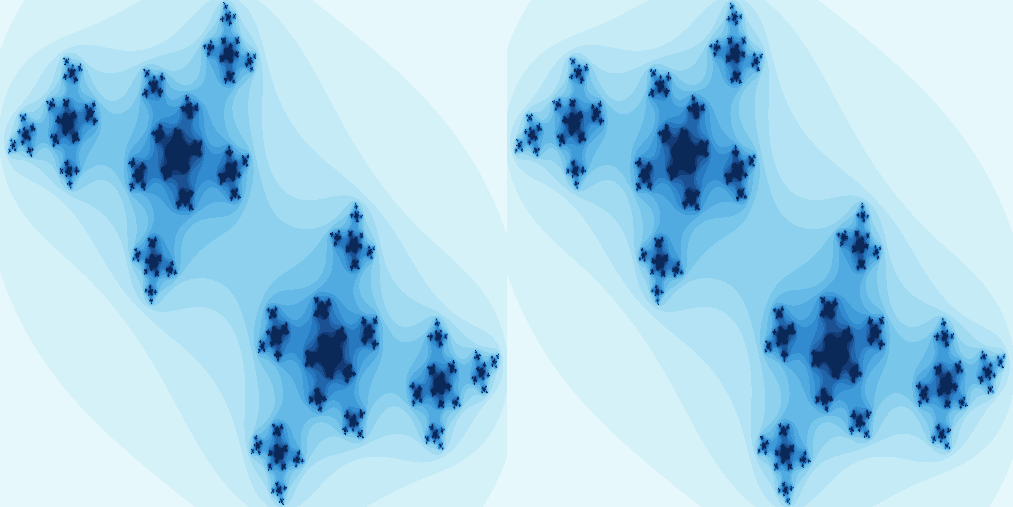

┌ Info: For better quality inline display of large images or thumbnails, load the Images package.
└ @ ImageShow /home/ec2-user/.julia/packages/ImageShow/9kpaq/src/showmime.jl:128


In [18]:
cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))

In [19]:
import Pkg; Pkg.add("Plotly")
using Plotly

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [20]:
import Pkg; Pkg.add("Plots")
using Plots; plotly()
#Pkg.add("WebIO")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


Plots.PlotlyBackend()

In [22]:

x = repeat(the_range, inner = 10)
speedup = jltimes ./ cutimes
Plots.scatter(
  log2.(x), [speedup, fill(1.0, length(speedup))], 
  label = ["cuda" "cpu"], markersize = 2, markerstrokewidth = 0,
  legend = :right, xlabel = "2^N", ylabel = "speedup"
)

<!DOCTYPE html>
 
 
 Plots.jl

In [23]:

Pkg.add("Flux")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [26]:
#. Some code from here: https://fluxml.ai/Flux.jl/stable/gpu/
using CuArrays

W = cu(rand(2, 5)) # a 2×5 CuArray
b = cu(rand(2))

predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = cu(rand(5)), cu(rand(2)) # Dummy data
loss(x, y) # ~ 3

0.2903893f0

In [1]:
using Flux
m = Dense(10,5) |> gpu
x = rand(10) |> gpu
m(x)

Tracked 5-element Array{Float32,1}:
  0.51474154f0
 -0.5914022f0 
 -0.32764545f0
  0.06337617f0
 -0.50094175f0

In [2]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, params
using Base.Iterators: repeated, partition
using CuArrays

# Classify MNIST digits with a convolutional network

imgs = MNIST.images()

labels = onehotbatch(MNIST.labels(), 0:9)

# Partition into batches of size 1,000
train = [(cat(float.(imgs[i])..., dims = 4), labels[:,i])
         for i in partition(1:60_000, 1000)]

use_gpu = true # helper to easily switch between gpu/cpu

todevice(x) = use_gpu ? gpu(x) : x




┌ Warning: CuArrays.jl only supports CUDNN v7.6 or higher
└ @ CuArrays /home/ec2-user/.julia/packages/CuArrays/HE8G6/src/CuArrays.jl:121
┌ Warning: Error requiring CuArrays from Flux:
│ LoadError: UndefVarError: libcudnn not defined
│ Stacktrace:
│  [1] getproperty(::Module, ::Symbol) at ./Base.jl:13
│  [2] top-level scope at /home/ec2-user/.julia/packages/Flux/qXNjB/src/cuda/cuda.jl:26
│  [3] include at ./boot.jl:328 [inlined]
│  [4] include_relative(::Module, ::String) at ./loading.jl:1105
│  [5] include at ./Base.jl:31 [inlined]
│  [6] include(::String) at /home/ec2-user/.julia/packages/Flux/qXNjB/src/Flux.jl:1
│  [7] top-level scope at /home/ec2-user/.julia/packages/IJulia/yLI42/src/kernel.jl:52
│  [8] eval at ./boot.jl:330 [inlined]
│  [9] eval at /home/ec2-user/.julia/packages/Flux/qXNjB/src/Flux.jl:1 [inlined]
│  [10] (::Flux.var"#150#154")() at /home/ec2-user/.julia/packages/Requires/qy6zC/src/require.jl:85
│  [11] err(::Any, ::Module, ::String) at /home/ec2-user/.julia/package

todevice (generic function with 1 method)

In [30]:

train = todevice.(train)

# Prepare test set (first 1,000 images)
tX = cat(float.(MNIST.images(:test)[1:1000])..., dims = 4) |> todevice
tY = onehotbatch(MNIST.labels(:test)[1:1000], 0:9) |> todevice


10×1000 Flux.OneHotMatrix{CuArray{Flux.OneHotVector,1,Nothing}}:
 0  0  0  1  0  0  0  0  0  0  1  0  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  1  0  0  1  0  0  0  0  0  0  0     1  0  0  0  0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  1  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  1  0  1  0  0  1     0  0  0  0  1  0  0  0  0  0  0  1

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/ec2-user/.julia/packages/GPUArrays/1wgPO/src/indexing.jl:16


In [31]:

m = todevice(Chain(
  Conv((2,2), 1=>16, relu),
  MaxPool((2, 2)),
  Conv((2,2), 16=>8, relu),
  MaxPool((2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10), softmax
))


Chain(Conv((2, 2), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((2, 2), 16=>8, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), #17, Dense(288, 10), softmax)

In [32]:

loss(x, y) = crossentropy(m(x), y)

loss (generic function with 1 method)

In [25]:
# train
Flux.train!(loss, params(m), train, ADAM())

ErrorException: CuArray only supports bits types

In [ ]:
Pkg.add("FileIO")
Pkg.add("ImageShow")


In [ ]:
using Colors, FileIO, ImageShow
N = 7
img = tX[:, :, 1:1, N:N]
println("Predicted: ", Flux.onecold(m(gpu(img))) .- 1)

save("results/test.png", collect(tX[:, :, 1, N]))

In [35]:
import Pkg; Pkg.add("BSON")

 Resolving package versions...
 Installed BSON ─ v0.2.5
  Updating `~/.julia/environments/v1.3/Project.toml`
  [fbb218c0] + BSON v0.2.5
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [fbb218c0] + BSON v0.2.5


┌ Info: Loading data set
└ @ Main In[39]:18
┌ Info: Constructing model...
└ @ Main In[39]:45
┌ Info: Loading model...
└ @ Main In[39]:68
┌ Info: Precompiling model...
└ @ Main In[39]:74
┌ Info: Beginning training loop...
└ @ Main In[39]:94


CuError: CUDA error: out of memory (code 2, ERROR_OUT_OF_MEMORY)